# Spectral Loss for Fundamental Mode of N2 as outer air region widens

Here we compare the spectral loss for the N2 configuration to that of N1 as we increase the outer air region of N2. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fiberamp.fiber.microstruct.bragg import BraggExact
from step_exact import plotlogf
from ngsolve.webgui import Draw
from scipy.optimize import newton

importing NGSolve-6.2.2203-56-g47f483033


# Some up front results

We expected that as the thickness of the buffer layer increased in N2, the loss profile would approach N1.  This didn't turn out to be true for any of the thicknesses we tried.  As the thickness increases, the profile of N2 remains with lower loss than N1, in fact it appears to remain about unchanged, still on average with a two order of magnitude reduction.  It appears that so long as a reflecting layer exists at the outer boundary, however far away, the fundamental mode "feels" this and has lower loss than if it were in the open.  Here's what that looks like for a pretty thick buffer layer:

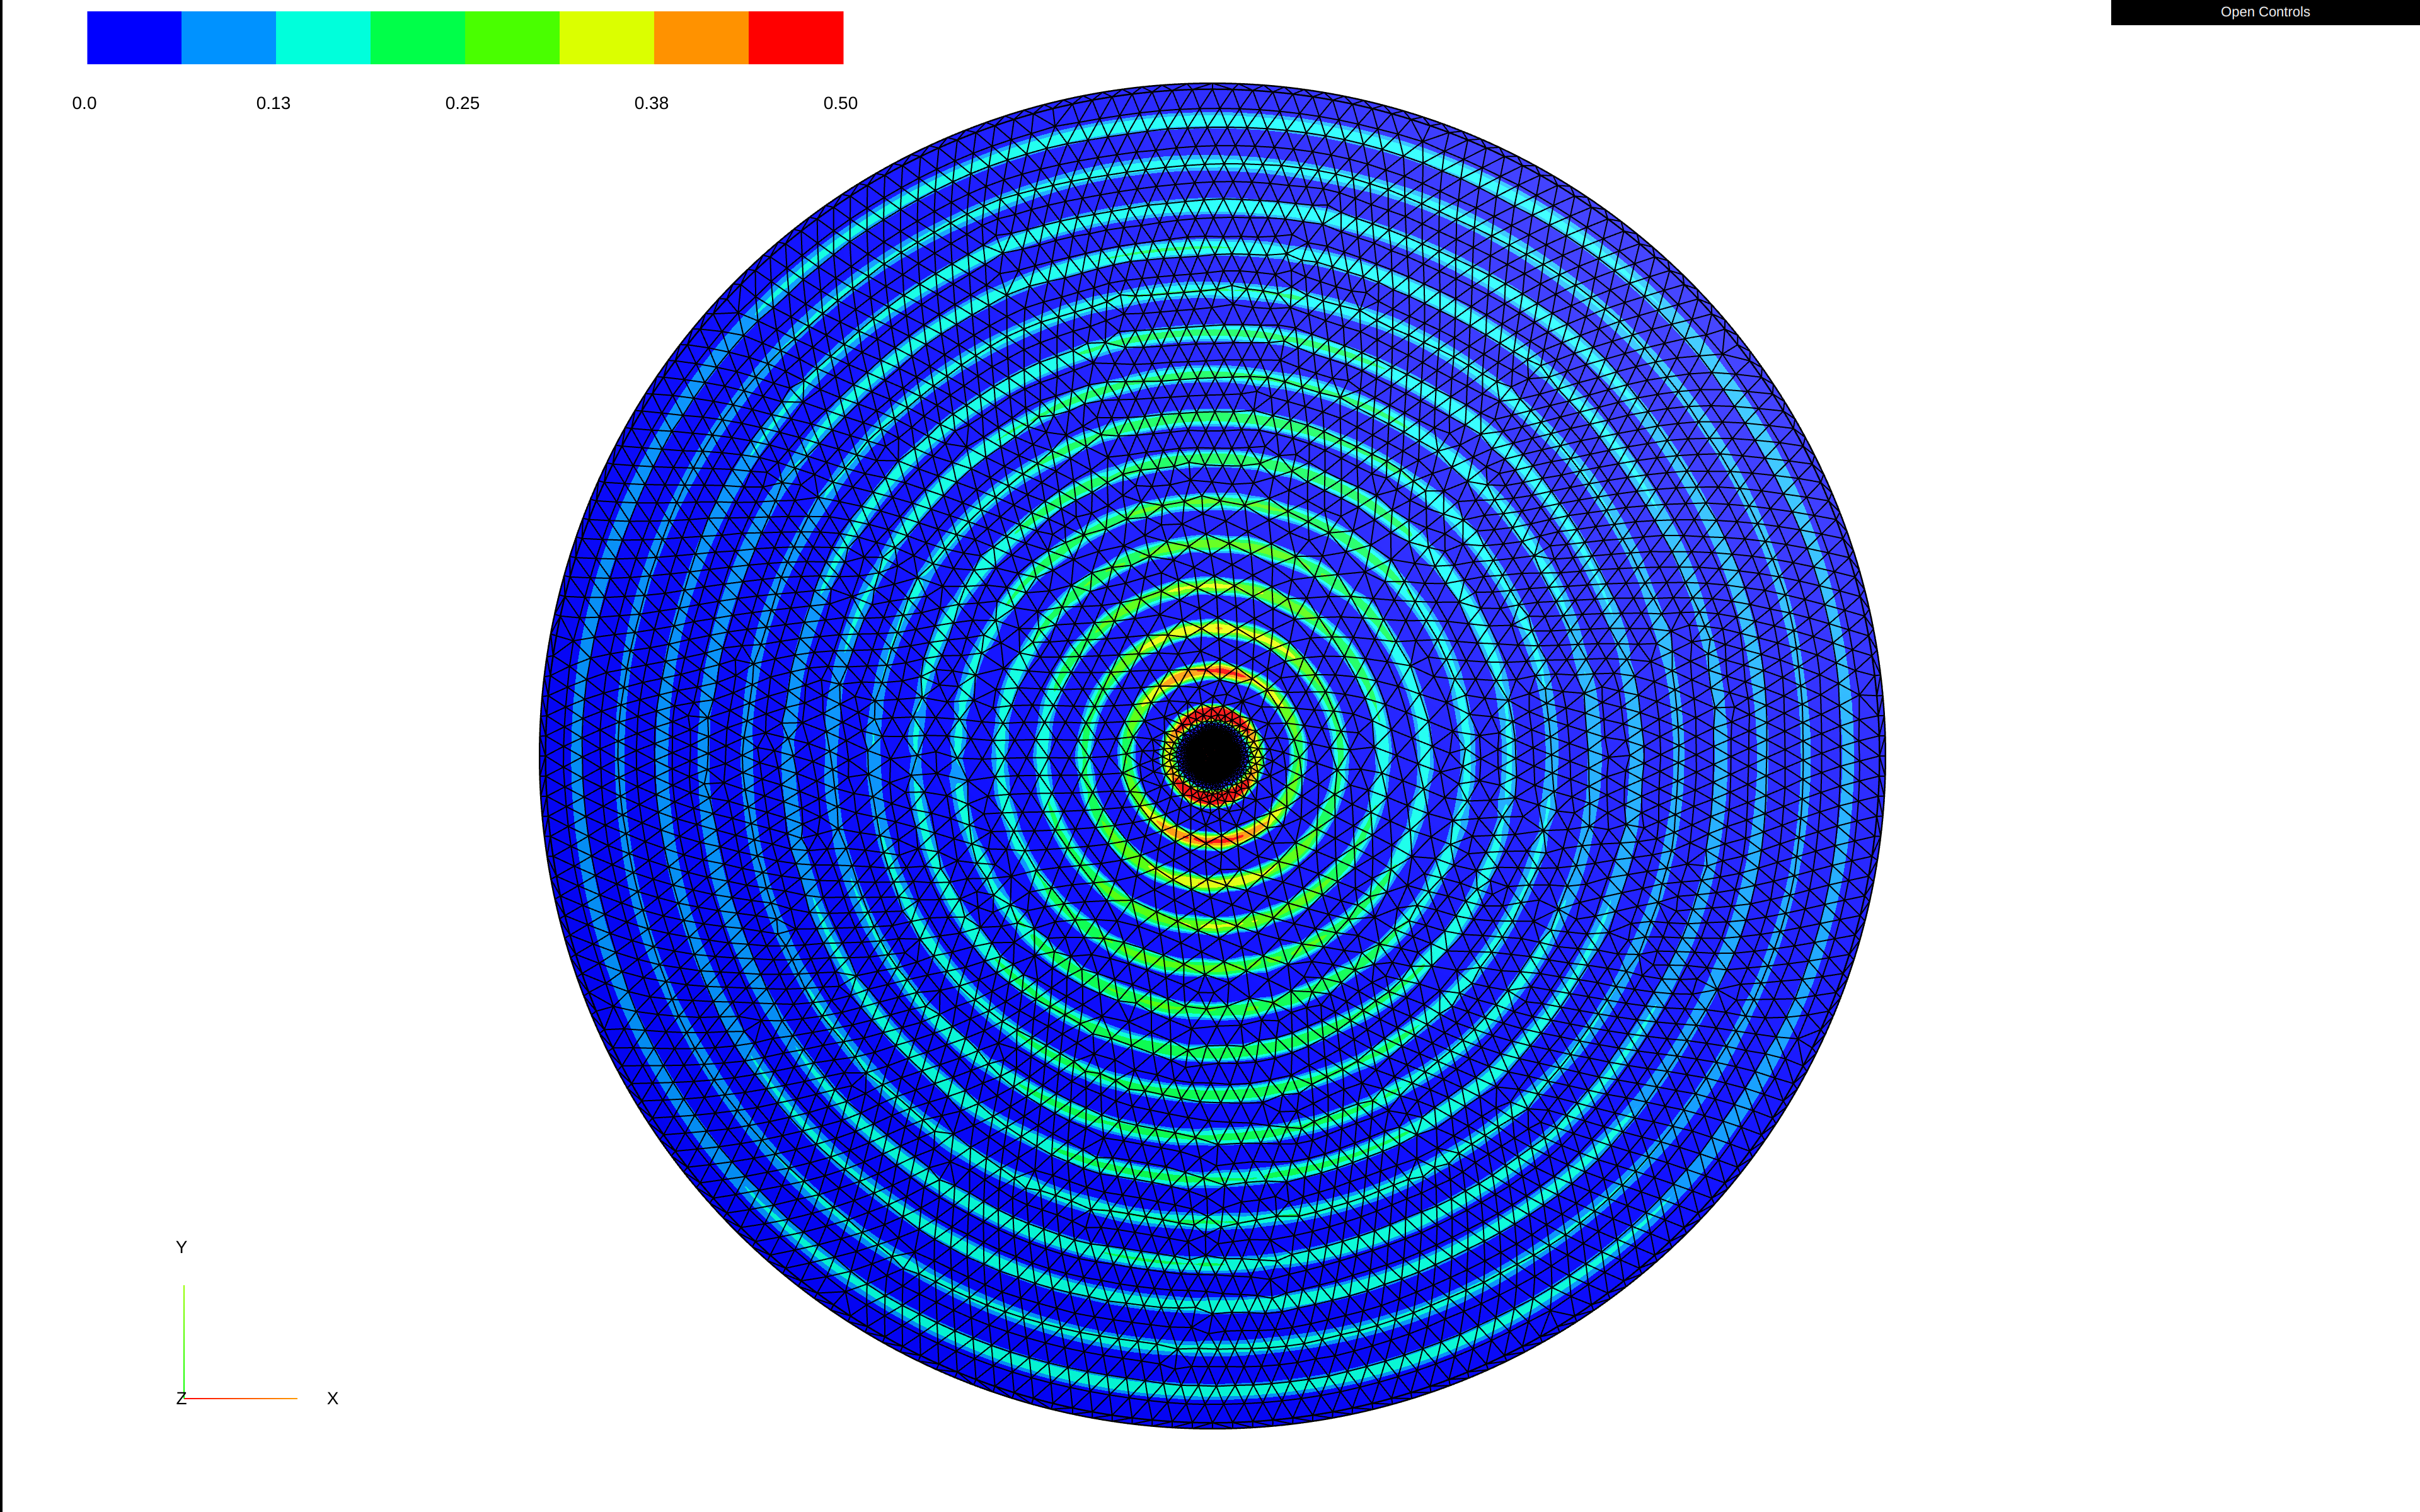

In [72]:
from IPython.display import Image
Image("images/bigreflect.png")

If we look at the fundamental mode in the center (too dark to see above) we see this:

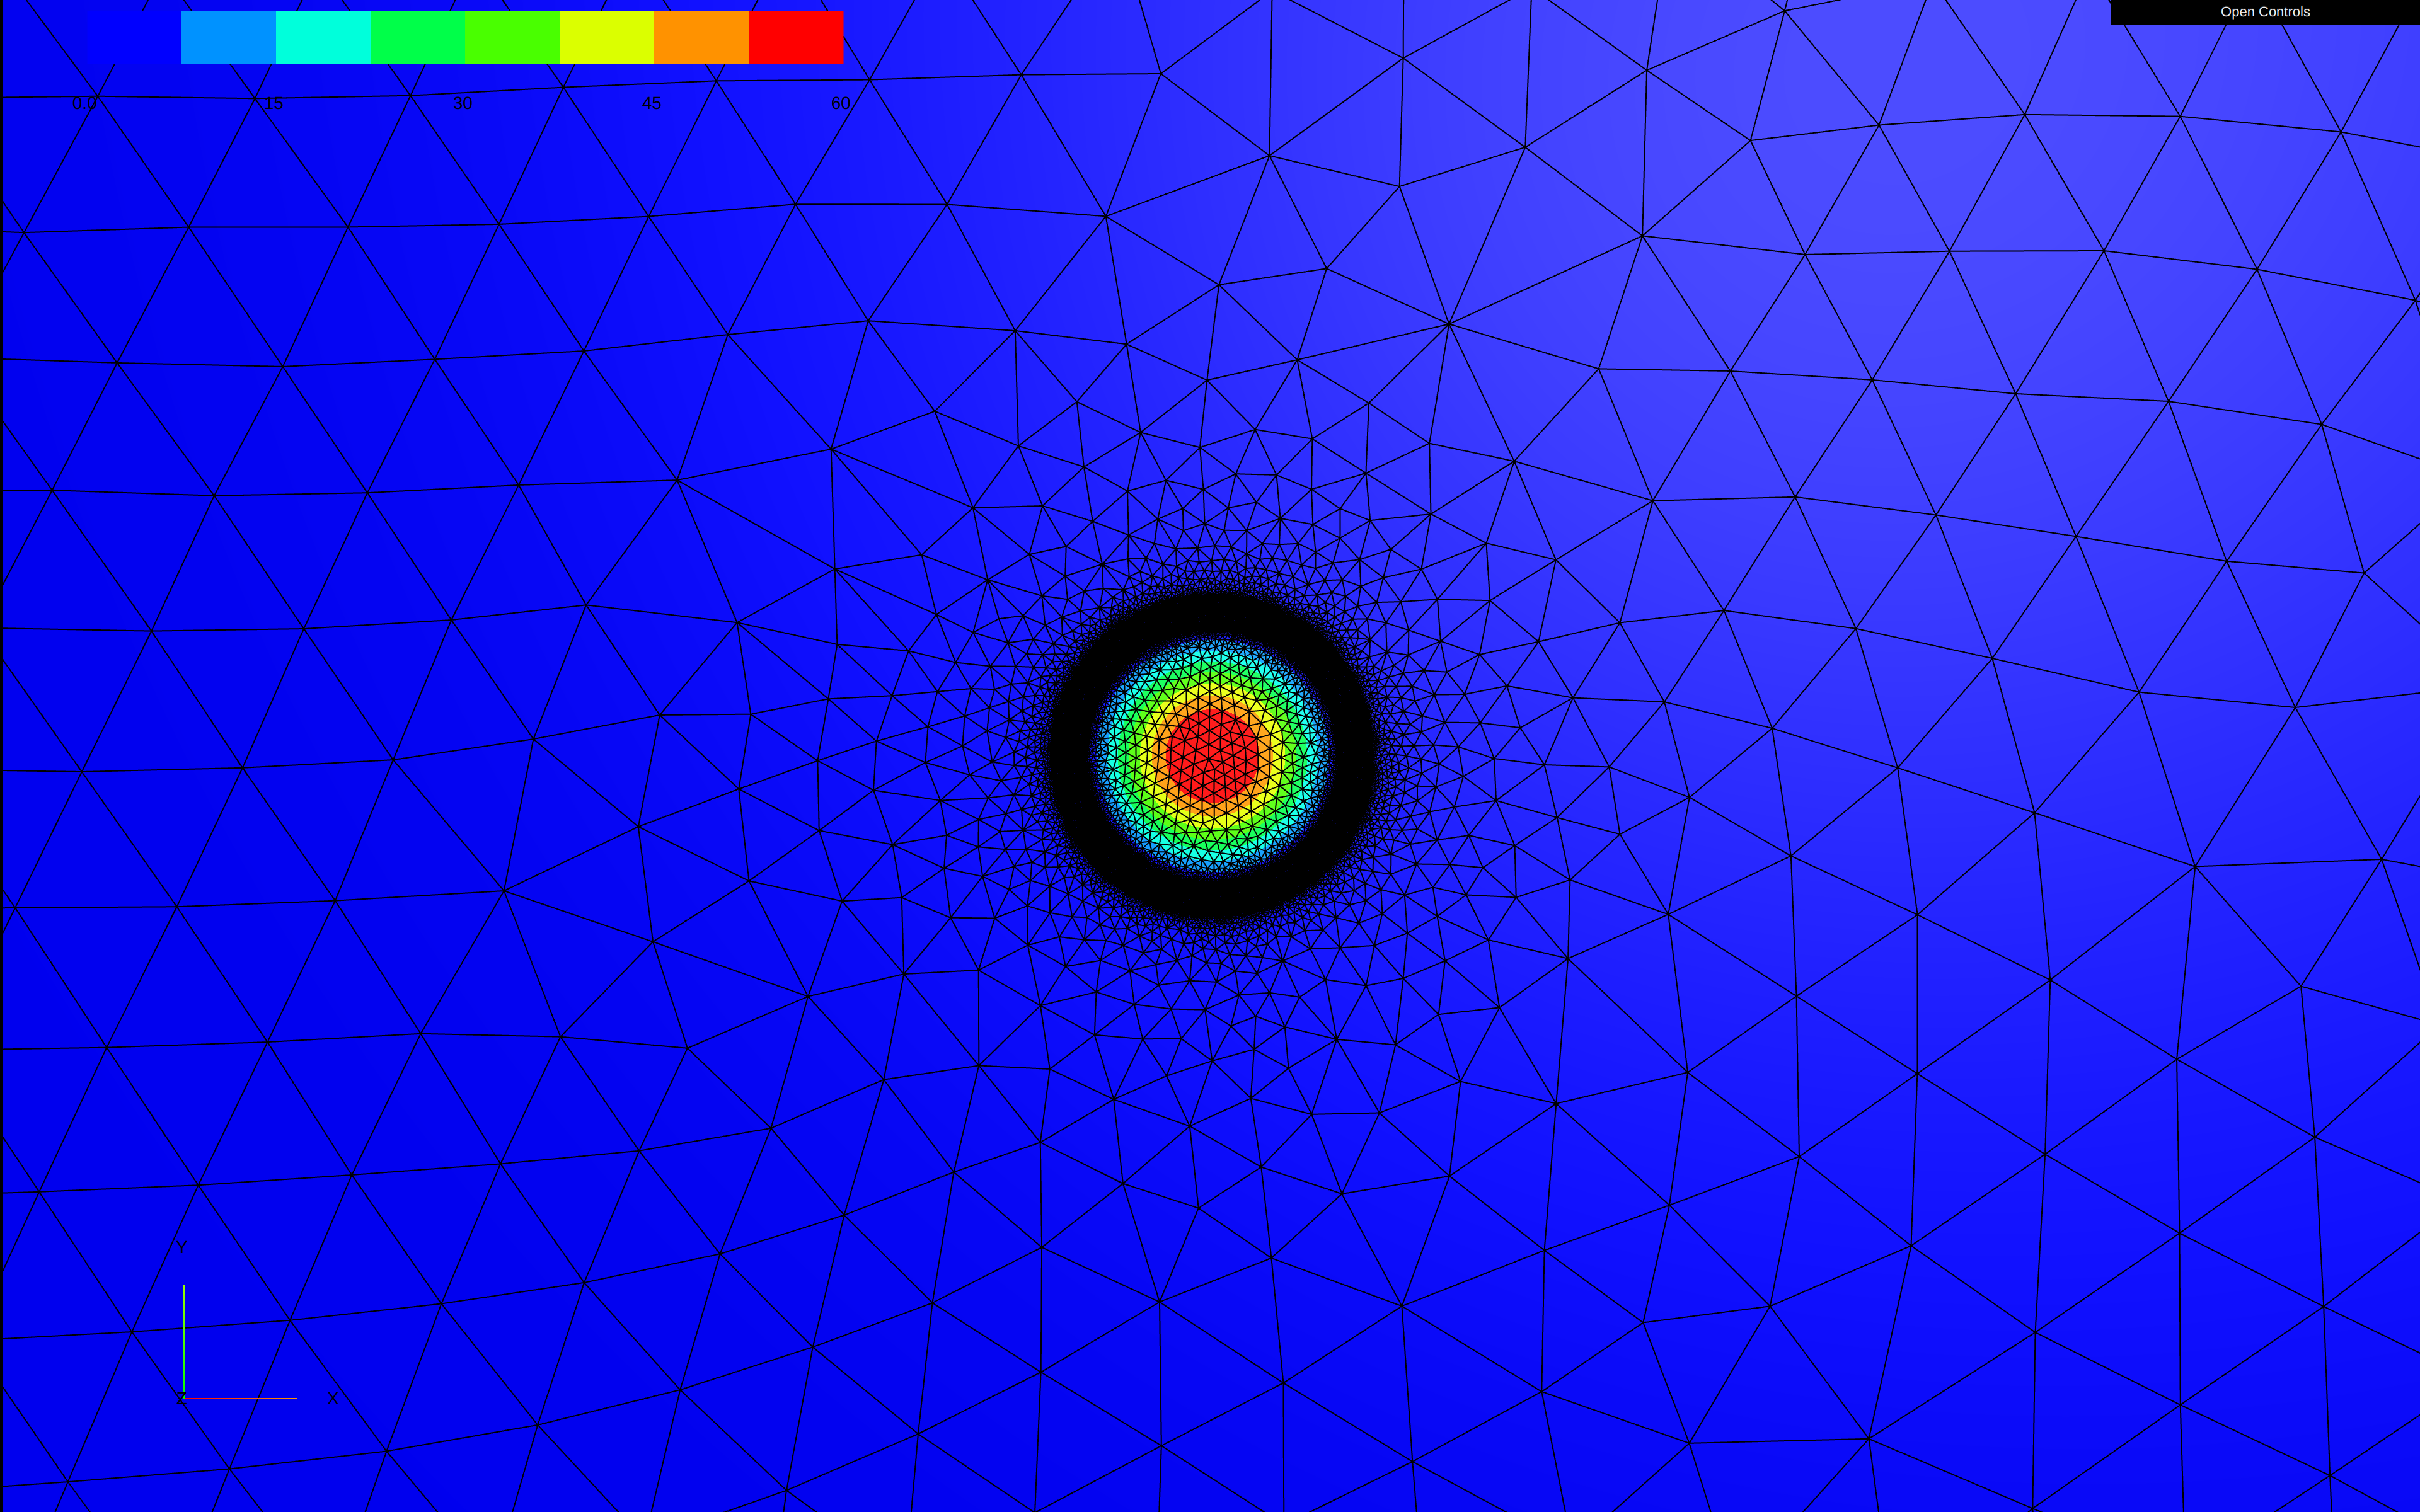

In [74]:
Image("images/smallcenter.png")

Note that the first image and second image do not have the same color scale.  The waves in the outer region in the top region are two orders of magnitude smaller than the core mode.

Below we run through the process of finding the spectral loss profiles and comparing them.

# Initialize

In [2]:
n = 300
wls = np.linspace(1.4e-6, 2e-6, n+1)
outer = 'h2'
nu = 1

N1betas = np.load('data/N1_wls.npy')

In [3]:
n_air = 1.00027717
n_glass = 1.4388164768221814
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air, lambda x : n_glass]

d = 4.0775e-05
ts = [d , 1e-5, d, 1.5e-5]

A = BraggExact(ts=ts, ns=ns, no_mesh=True)

In [4]:
# Formula for loss spikes from article

ms = np.arange(11,15,1)

n1 = A.ns[0]  # Inner (core) index
n2 = A.ns[1]  # Cladding index

d = 15*2/3*1e-6

ls = (2 * n1 * d / ms * ((n2/n1)**2 - 1)**.5)  # when n2 depends on ls, need solver
ls

array([1.88042411e-06, 1.72372210e-06, 1.59112809e-06, 1.47747609e-06])

# Show N1 profile for comparison

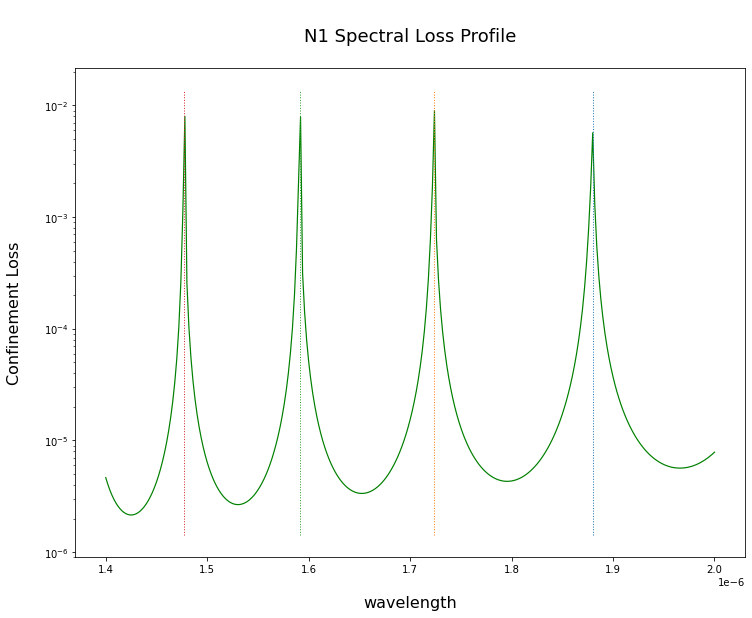

In [5]:
fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nN1 Spectral Loss Profile\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N1betas.imag, color='green', linewidth=1.2)
ax.set_yscale('log')
m, M = ax.get_ylim()

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')

# Base N2 Study

In [6]:
N2betas_base = np.zeros_like(wls, dtype=complex)
k_lows = np.zeros_like(wls)

for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, maxhs=[100 ,100, 100, 100], wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    k_lows[i] = k_low
    guess = np.array(.9999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_base[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.32748602157413-0.0001562763823289439j) . Residual of determinant:  1.1133003289289505e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (67.231388694642-0.0001578900804305115j) . Residual of determinant:  3.962377121961005e-12 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14091441191505-1.7983732407459479e-07j) . Residual of determinant:  2.034953156139753e-10 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04538103871661-1.6264008640462176e-07j) . Residual of determinant:  1.1725035547621632e-10 


     --------------------  5/301: wavelength: 1.408e-06  ------------------

Scaled beta:  (63.68965074886855-0.0001405494736081772j) . Residual of determinant:  1.3988910191315328e-13 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60183582472058-0.0001321886805366002j) . Residual of determinant:  4.2143338365555516e-13 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.521292420214046-2.6234776055261255e-06j) . Residual of determinant:  3.2717206850992294e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

Scaled beta:  (63.43564864097496-1.701014397303641e-06j) . Residual of determinant:  9.067969195392282e-12 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled beta:  (63.35028483801723-1.193834854989019e-06j) . Residual of determinant:  1.184827602146348e-11 


     --------------------  46/301: wavelength: 1.49e-06  --------------------     

Scaled b

scaling guess: 2
scaling guess: 3
Scaled beta:  (60.34800983997422-3.413081973362792e-07j) . Residual of determinant:  7.626240529296075e-11 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.27080807614163-3.870135042832254e-07j) . Residual of determinant:  1.5348687694166139e-10 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.193801730436746-4.4467900895181673e-07j) . Residual of determinant:  3.873251585471691e-11 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.11698960967507-5.186548690097163e-07j) . Residual of determinant:  3.759411973278915e-11 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

Scaled beta:  (60.04037036870653-6.154626606877117e-07j) . Residual of determinant:  4.7808962398552915e-11 


     ----

Scaled beta:  (57.47733101099399-2.1428822402198986e-07j) . Residual of determinant:  1.899765092865115e-10 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

Scaled beta:  (57.407298629746585-2.08797023383878e-07j) . Residual of determinant:  2.8315931505183682e-11 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

Scaled beta:  (57.337436811413994-2.0448305251662683e-07j) . Residual of determinant:  1.0190202158641412e-11 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.26774489467135-2.0124586500593785e-07j) . Residual of determinant:  9.606541937936298e-11 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.19822222512115-1.9901003033759222e-07j) . Residual of determinant:  1.6448136452983345e-10 


     ------------

Scaled beta:  (54.86619326110254-1.370484141101898e-05j) . Residual of determinant:  1.595573117651797e-12 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.8020876117511-2.5741858482700956e-05j) . Residual of determinant:  5.600841498411169e-13 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (54.70825978371607-0.00017878993689889332j) . Residual of determinant:  3.734861247690534e-15 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (54.67524025298591-8.27037285379224e-05j) . Residual of determinant:  5.695126032548719e-14 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

scaling guess: 1
scaling

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (52.542128149086395-2.75018583918121e-07j) . Residual of determinant:  5.33834925134462e-11 


     --------------------  199/301: wavelength: 1.7959999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.48359516599714-2.7506431092571743e-07j) . Residual of determinant:  7.152899587587453e-11 


     --------------------  200/301: wavelength: 1.798e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (52.425192390635-2.760005078578793e-07j) . Residual of determinant:  5.6126120295210615e-11 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.366919368770105-2.778293599865099e-07j) . Residual of determinant:  4.8527929107936445e-11 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

Scaled beta:  (52.308775648391936-2.805644740724078e-07

Scaled beta:  (50.351340037777504-1.3151172295015743e-05j) . Residual of determinant:  8.173855193583976e-14 


     --------------------  238/301: wavelength: 1.8739999999999998e-06  --------------------     

Scaled beta:  (50.29739080471971-2.049206293907374e-05j) . Residual of determinant:  9.212987841874365e-13 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

Scaled beta:  (50.24347527951102-3.4095041874464546e-05j) . Residual of determinant:  9.975650916252969e-13 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (50.198134682034386-2.744145915949683e-05j) . Residual of determinant:  7.291317678272405e-13 


     --------------------  241/301: wavelength: 1.8799999999999998e-06  --------------------     

Scaled beta:  (50.13875152788341-6.867932579412708e-05j) . Residual of 

scaling guess: 1
Scaled beta:  (48.28801789758153-4.1455541726493547e-07j) . Residual of determinant:  2.7934102076074893e-11 


     --------------------  278/301: wavelength: 1.954e-06  --------------------     

Scaled beta:  (48.23856986122066-4.087099801666398e-07j) . Residual of determinant:  1.1265083703146477e-10 


     --------------------  279/301: wavelength: 1.956e-06  --------------------     

Scaled beta:  (48.189223037239415-4.0394498043549036e-07j) . Residual of determinant:  5.931775604252742e-11 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

Scaled beta:  (48.13997709690915-4.002033322374384e-07j) . Residual of determinant:  5.812476534329692e-11 


     --------------------  281/301: wavelength: 1.96e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (48.0908317140176-3.9743925861744694e-07j) . Residual of determinant:  2.614734895648494e-11 


     --------------------  282/301: wa

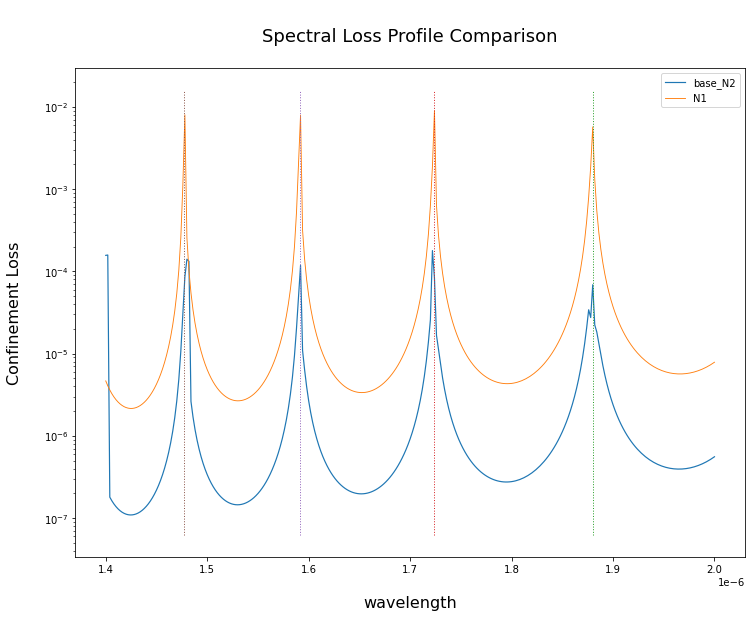

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag, linewidth=1.2, label='base_N2')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')
ax.legend()

ax.set_yscale('log')
m, M = ax.get_ylim()

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# Observation on real part of Fundamental Mode

From interactive plots, I observed that at a fixed wavelength, the relative position of the real part of the fundamental mode to k_low does not change appreciably.  Thus, one possible way of filtering out the (small tube) fundamental from other modes is to find this location at each wavelength from the real parts of the base betas we computed above.

We verify this in the search_center_check notebook.  We found that using these is good if we do upscaling to modify the search centers if the newton solver fails

In [20]:
centers = N2betas_base.real


# T=1.25

In [21]:
N2betas_t1 = np.zeros_like(wls, dtype=complex)

t1 = 1.25
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t1[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33111751310666-8.34781658448785e-05j) . Residual of determinant:  5.4380121716890785e-12 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23503600949873-8.411433524424617e-05j) . Residual of determinant:  2.2276999796440848e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.1409363482736-3.980583159694321e-06j) . Residual of determinant:  7.958461707800549e-12 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04540101373942-3.672936631167538e-06j) . Residual of determinant:  1.0655007028963954e-12 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (66.9501384901813-3.424460715349786e-06j) . Re

Scaled beta:  (63.691506106605424-7.072925292725978e-05j) . Residual of determinant:  1.7484713910970895e-14 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.605229142558905-7.902718952420143e-05j) . Residual of determinant:  1.2567931919370776e-13 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.52147688557713-1.8966625075508234e-05j) . Residual of determinant:  2.2956512556315966e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

Scaled beta:  (63.435785824913275-1.6528707910294388e-05j) . Residual of determinant:  9.29511171580878e-12 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.35039041383529-1.426437983374144e-05j) . Residual of determinant:  2.086132220408041e-12 


     --------------------  46/301: wavelength: 1.49e-06  ----------------

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (60.27085114930368-8.607536342692478e-06j) . Residual of determinant:  2.3894216847300903e-12 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.193850727941-9.629657211212445e-06j) . Residual of determinant:  8.539104176748667e-12 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (60.11704603846967-1.0858216679184047e-05j) . Residual of determinant:  3.1916954164438946e-12 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

Scaled beta:  (60.04043625096331-1.2340668243197773e-05j) . Residual of determinant:  5.239889839785834e-12 


     --------------------  87/301: wavelength: 1.572e-06  --------------------     

Scaled beta:  (59.964020538375955-1.4134772330725919e-05j) . Residual of determinant:  1.467632939475520

Scaled beta:  (57.33745844519971-4.748967721548222e-06j) . Residual of determinant:  3.185519477638746e-12 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.26776621002327-4.698723380857163e-06j) . Residual of determinant:  8.790984451562416e-12 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

Scaled beta:  (57.19824332229508-4.668215616784265e-06j) . Residual of determinant:  1.731693206695104e-12 


     --------------------  126/301: wavelength: 1.6499999999999999e-06  --------------------     

Scaled beta:  (57.128889128765714-4.6567732044902735e-06j) . Residual of determinant:  7.978779777978928e-12 


     --------------------  127/301: wavelength: 1.652e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.059702983188416-4.664021278036778e-06j) . Residual of determinant:  3.5697544865152128e-12 


     --------------------  128/301: wavelength: 1.654e-

Scaled beta:  (54.67577168285243-6.631974132250611e-05j) . Residual of determinant:  1.2151032196491943e-13 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

Scaled beta:  (54.61562077434141-2.4598871163636167e-05j) . Residual of determinant:  1.771437120033835e-12 


     --------------------  165/301: wavelength: 1.7279999999999998e-06  --------------------     

Scaled beta:  (54.55141277143854-2.8709659319557852e-05j) . Residual of determinant:  1.387780317409763e-12 


     --------------------  166/301: wavelength: 1.73e-06  --------------------     

Scaled beta:  (54.487812410588084-2.912909125968792e-05j) . Residual of determinant:  8.354422002492334e-13 


     --------------------  167/301: wavelength: 1.7319999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.42456244282899-2.792005632420553e-05j) . Residual of determinant:  3.56070563158322e-12 


     --------------------  168/

Scaled beta:  (51.8482596046989-7.864221098097961e-06j) . Residual of determinant:  1.4756399293598874e-11 


     --------------------  211/301: wavelength: 1.82e-06  --------------------     

Scaled beta:  (51.791260745682415-8.156675519299357e-06j) . Residual of determinant:  1.8135016897900688e-12 


     --------------------  212/301: wavelength: 1.8219999999999999e-06  --------------------     

Scaled beta:  (51.73438689577381-8.484685773647703e-06j) . Residual of determinant:  9.801700367604612e-12 


     --------------------  213/301: wavelength: 1.8239999999999998e-06  --------------------     

Scaled beta:  (51.67763762718061-8.851984099526387e-06j) . Residual of determinant:  7.611073680803332e-13 


     --------------------  214/301: wavelength: 1.826e-06  --------------------     

Scaled beta:  (51.621012513379895-9.262886790062715e-06j) . Residual of determinant:  5.1989183009625285e-12 


     --------------------  215/301: wavelength: 1.828e-06  ------------------

Scaled beta:  (49.715475129296664-2.9085275375019913e-05j) . Residual of determinant:  4.1194911375212135e-13 


     --------------------  250/301: wavelength: 1.8979999999999999e-06  --------------------     

Scaled beta:  (49.66297327134173-2.724069922437777e-05j) . Residual of determinant:  5.898827339029571e-13 


     --------------------  251/301: wavelength: 1.9e-06  --------------------     

Scaled beta:  (49.61060070868669-2.5470071416105904e-05j) . Residual of determinant:  3.4071053412088165e-13 


     --------------------  252/301: wavelength: 1.9019999999999997e-06  --------------------     

Scaled beta:  (49.55835221328564-2.380740440599543e-05j) . Residual of determinant:  4.4177779652171653e-13 


     --------------------  253/301: wavelength: 1.904e-06  --------------------     

Scaled beta:  (49.50622406483935-2.2267927828587163e-05j) . Residual of determinant:  4.801255160809386e-12 


     --------------------  254/301: wavelength: 1.9059999999999998e-06  ---

Scaled beta:  (47.60487440165948-9.426986387932499e-06j) . Residual of determinant:  2.759477809027017e-13 


     --------------------  292/301: wavelength: 1.982e-06  --------------------     

Scaled beta:  (47.556814780136996-9.594191651234286e-06j) . Residual of determinant:  3.442028896238432e-12 


     --------------------  293/301: wavelength: 1.984e-06  --------------------     

Scaled beta:  (47.508852024776196-9.782558427031872e-06j) . Residual of determinant:  8.253018694366873e-12 


     --------------------  294/301: wavelength: 1.9859999999999997e-06  --------------------     

Scaled beta:  (47.46098583271954-9.993264566278933e-06j) . Residual of determinant:  2.46099047684297e-12 


     --------------------  295/301: wavelength: 1.988e-06  --------------------     

Scaled beta:  (47.41321590243629-1.0227660315488796e-05j) . Residual of determinant:  1.3016528411023593e-12 


     --------------------  296/301: wavelength: 1.99e-06  --------------------     

Scale

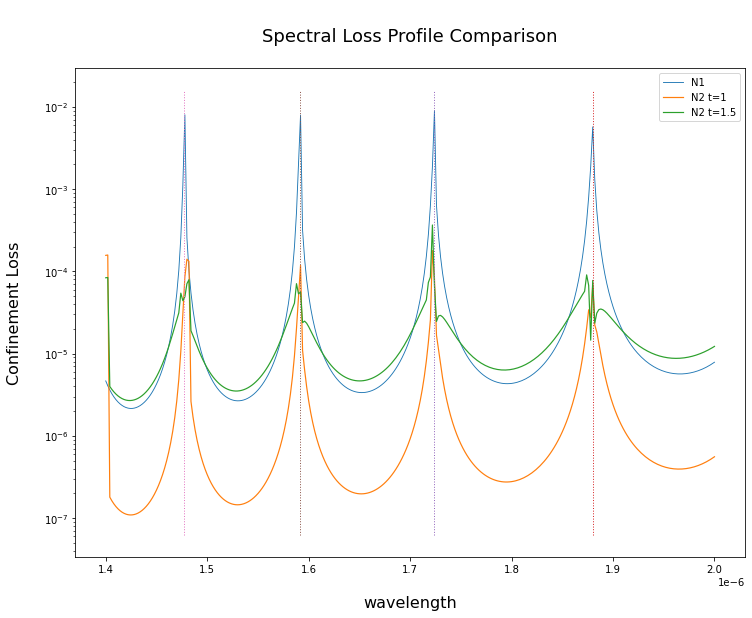

In [24]:
%matplotlib inline

fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')
ax.plot(wls, -N2betas_base.imag, linewidth=1.2, label='N2 t=1')
ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.5')
ax.legend()

ax.set_yscale('log')
m, M = ax.get_ylim()

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T=1.5

In [25]:
centers = N2betas_t1.real


In [26]:
N2betas_t2 = np.zeros_like(wls, dtype=complex)

t1 = 1.5
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = .999999
    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t2[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.33278825145544-1.0735740379385656e-06j) . Residual of determinant:  2.7530278475991335e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.23670761154311-9.340295421505331e-07j) . Residual of determinant:  5.303123623595116e-12 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14090194717396-8.272842438311472e-07j) . Residual of determinant:  7.295745927358083e-13 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04536980447683-7.44374124295471e-07j) . Residual of determinant:  5.045477439246706e-12 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.9501098064571-6.792678758448776e-07j) . Residual of determinant:  2.46672366

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (63.693072253741335-2.6527201635720025e-05j) . Residual of determinant:  3.1853688695601196e-13 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.60694213745717-1.8305250326352388e-05j) . Residual of determinant:  2.447796474353012e-13 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.5213944776938-4.383727657728481e-05j) . Residual of determinant:  1.0970150597442303e-12 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.435834114836595-4.742701883206059e-05j) . Residual of determinant:  7.846112222184161e-13 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled beta:  (63.350521435690084-4.9890788488385964e-05j) . Residual of determinant:  1.567727512838605e-12 


     -----------------

Scaled beta:  (60.42538974057903-1.2456733755476785e-06j) . Residual of determinant:  1.870535109108381e-11 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

Scaled beta:  (60.347989316420026-1.3845462697907375e-06j) . Residual of determinant:  4.577721960197548e-12 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scaled beta:  (60.270784879115354-1.5555407987427377e-06j) . Residual of determinant:  2.1674656702781186e-13 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.193775168166816-1.7685852131181346e-06j) . Residual of determinant:  6.1096102369125705e-12 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

Scaled beta:  (60.11695874210796-2.0377885515228542e-06j) . Residual of determinant:  6.342453655014768e-12 


     --------------------  86/301: wavelength: 1.57e-06  -----------------

Scaled beta:  (57.47731843017701-9.550101567619247e-07j) . Residual of determinant:  4.8659378503400085e-12 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.407286399577245-9.274898294152551e-07j) . Residual of determinant:  1.9045377377464125e-11 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.33742486108417-9.053904718262576e-07j) . Residual of determinant:  1.2414210356715254e-11 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.267733159810675-8.882029187704941e-07j) . Residual of determinant:  7.567463832076494e-13 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

Scaled beta:  (57.19821064625994-8.755363421152825e-07j) . Residual of determinant:  9.300728514

scaling guess: 1
Scaled beta:  (54.66956571367097-9.818542515822947e-05j) . Residual of determinant:  8.281507380641811e-15 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.613605313413345-4.1286231061191126e-05j) . Residual of determinant:  1.450972135360167e-13 


     --------------------  165/301: wavelength: 1.7279999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.550531596845474-4.834587106385926e-05j) . Residual of determinant:  2.7227718118606023e-13 


     --------------------  166/301: wavelength: 1.73e-06  --------------------     

Scaled beta:  (54.487323818164796-5.135220344222198e-05j) . Residual of determinant:  1.231795438611737e-13 


     --------------------  167/301: wavelength: 1.7319999999999999e-06  --------------------     

Scaled beta:  (54.424307072032214-5.568745056462184e-05j) . Residual of determinant:  6.15725157458155e-1

Scaled beta:  (52.07746899845412-1.2807170332401973e-06j) . Residual of determinant:  1.0741723772189417e-11 


     --------------------  207/301: wavelength: 1.8119999999999998e-06  --------------------     

Scaled beta:  (52.019964681831674-1.309945851752629e-06j) . Residual of determinant:  4.114845937554252e-13 


     --------------------  208/301: wavelength: 1.814e-06  --------------------     

Scaled beta:  (51.96258692187261-1.3441630048663964e-06j) . Residual of determinant:  5.064058595258012e-13 


     --------------------  209/301: wavelength: 1.8159999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (51.90533526854128-1.3837870489392367e-06j) . Residual of determinant:  2.3124811152600595e-12 


     --------------------  210/301: wavelength: 1.8179999999999998e-06  --------------------     

Scaled beta:  (51.848209270371996-1.4293236334274902e-06j) . Residual of determinant:  1.8827553127656323e-13 


     --------------------  211/301: wavel

Scaled beta:  (49.92640319553147-6.021313613562524e-05j) . Residual of determinant:  2.557461337698299e-13 


     --------------------  246/301: wavelength: 1.89e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (49.873476113222466-6.407054723664608e-05j) . Residual of determinant:  2.729686125608481e-13 


     --------------------  247/301: wavelength: 1.8919999999999998e-06  --------------------     

Scaled beta:  (49.82068143867608-6.808548925472958e-05j) . Residual of determinant:  5.240487359399281e-15 


     --------------------  248/301: wavelength: 1.894e-06  --------------------     

Scaled beta:  (49.76801207547175-7.17229684830751e-05j) . Residual of determinant:  2.9037883896283317e-13 


     --------------------  249/301: wavelength: 1.8959999999999997e-06  --------------------     

Scaled beta:  (49.715463472877396-7.483553244530643e-05j) . Residual of determinant:  6.321304808574766e-13 


     --------------------  250/301: wavelengt

scaling guess: 1
Scaled beta:  (47.89523014946239-1.703001115736742e-06j) . Residual of determinant:  1.823034478226587e-12 


     --------------------  286/301: wavelength: 1.9699999999999998e-06  --------------------     

Scaled beta:  (47.846582683323916-1.706105228615868e-06j) . Residual of determinant:  2.209958279539741e-11 


     --------------------  287/301: wavelength: 1.972e-06  --------------------     

Scaled beta:  (47.79803381634638-1.7129691447594343e-06j) . Residual of determinant:  9.801874841264912e-12 


     --------------------  288/301: wavelength: 1.974e-06  --------------------     

Scaled beta:  (47.74958323441488-1.7236155682496344e-06j) . Residual of determinant:  1.066398080795208e-12 


     --------------------  289/301: wavelength: 1.976e-06  --------------------     

Scaled beta:  (47.70123062424798-1.7380998849331162e-06j) . Residual of determinant:  7.84934442094974e-12 


     --------------------  290/301: wavelength: 1.978e-06  --------------

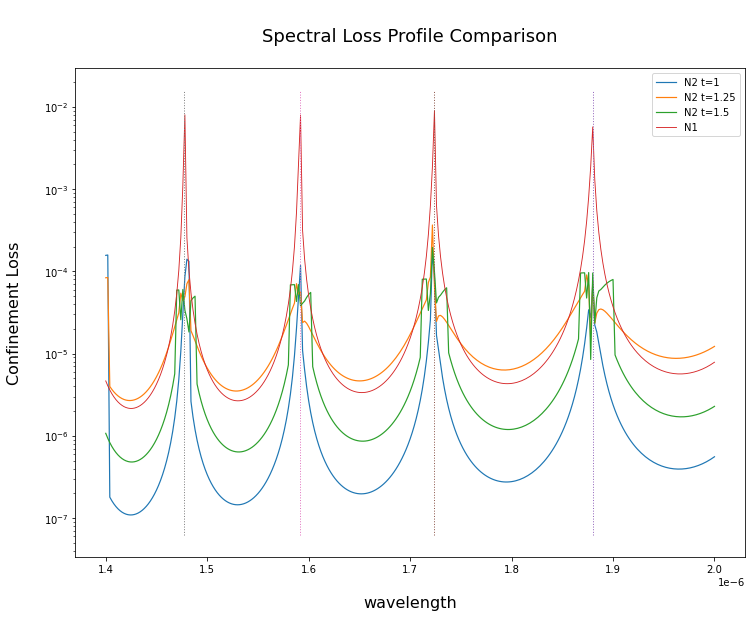

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag, linewidth=1.2, label='N2 t=1')
ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')

ax.legend()

ax.set_yscale('log')
m, M = ax.get_ylim()

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T=3

In [28]:
centers = N2betas_t1.real


In [29]:
N2betas_t3 = np.zeros_like(wls, dtype=complex)

t1 = 3
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t3[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.33279521775144-2.1536367453810738e-07j) . Residual of determinant:  6.914605533350283e-12 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.23671370943869-1.8671782020874637e-07j) . Residual of determinant:  4.425785048937748e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.14090737729984-1.6494042163878758e-07j) . Residual of determinant:  1.952421764761078e-10 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.04537471388214-1.4810526002315482e-07j) . Residual of determinant:  4.1037620612637456e-11 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

scaling guess: 1
Scaled beta:  (66.95011430587712-1.3493

scaling guess: 1
scaling guess: 2
Scaled beta:  (63.69347902485581-1.910565850679422e-05j) . Residual of determinant:  4.105850227874336e-13 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.607412071838105-2.302561198941591e-05j) . Residual of determinant:  1.6262153335338199e-12 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.52162854272182-2.501610168266472e-05j) . Residual of determinant:  6.05112040719513e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.43609545021045-2.6053131391788416e-05j) . Residual of determinant:  2.862621798112126e-12 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled beta:  (63.350235903398435-1.2879581884643478e-06j) . Residual of determinant:  4.495000590715931e-12 


     --------------------  46/301: wavelen

Scaled beta:  (60.50299485162251-2.2585886889318405e-07j) . Residual of determinant:  2.2373506078691292e-11 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

Scaled beta:  (60.425398119696155-2.4896990500964205e-07j) . Residual of determinant:  1.8034480946077524e-11 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.3479987010581-2.7724735482619563e-07j) . Residual of determinant:  2.7560938105177994e-11 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scaled beta:  (60.27079551566131-3.1221090050485673e-07j) . Residual of determinant:  7.22938448526103e-12 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.19378738535661-3.559962426896057e-07j) . Residual of determinant:  1.6278050751352523e-11 


     --------------------  85/301: wavelength: 1.56799999999

Scaled beta:  (57.617902546569916-2.0594175530765885e-07j) . Residual of determinant:  2.056902188784931e-12 


     --------------------  120/301: wavelength: 1.6379999999999998e-06  --------------------     

Scaled beta:  (57.547527324295295-1.9767451577162781e-07j) . Residual of determinant:  8.095809632233072e-13 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

Scaled beta:  (57.477323961461046-1.9082329879630267e-07j) . Residual of determinant:  1.0252757681607893e-11 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.40729178557175-1.8521408829152408e-07j) . Residual of determinant:  1.4257727439939757e-10 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

Scaled beta:  (57.337430132179435-1.8071034438270016e-07j) . Residual of determinant:  4.7139403416463495e-11 


     --------------------  124/301: wavelength: 1.64

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.93177198216693-4.068607030714153e-05j) . Residual of determinant:  3.698552964264846e-12 


     --------------------  160/301: wavelength: 1.718e-06  --------------------     

Scaled beta:  (54.86585114916881-9.169400429654898e-06j) . Residual of determinant:  1.2215806598700642e-12 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

Scaled beta:  (54.80148678120668-1.740964556395844e-05j) . Residual of determinant:  8.716203722386337e-13 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

Scaled beta:  (54.71258003560471-0.00016791295961122746j) . Residual of determinant:  3.6691305762024237e-17 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.67588103445046-3.3181083803253466e-17j) . Residual of determinant:  0.07444866058973537 


     -----

Scaled beta:  (52.42518423379854-2.3965990761249476e-07j) . Residual of determinant:  1.745824080001504e-11 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.36691118244495-2.4050909195497344e-07j) . Residual of determinant:  8.429319220897473e-11 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

Scaled beta:  (52.3087674061464-2.4213513302167186e-07j) . Residual of determinant:  1.3536920884808554e-11 


     --------------------  203/301: wavelength: 1.804e-06  --------------------     

Scaled beta:  (52.25075245438971-2.4455034280022434e-07j) . Residual of determinant:  1.3327568413388213e-11 


     --------------------  204/301: wavelength: 1.806e-06  --------------------     

Scaled beta:  (52.192865878002166-2.477771753451501e-07j) . Residual of determinant:  5.447047868924661e-12 


     --------------------  205/301: wavelength: 1.8079999999999999e-06  

Scaled beta:  (50.242757292017345-2.3168796233864723e-05j) . Residual of determinant:  5.810201234931544e-13 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (50.19901258781762-9.7010346064076e-07j) . Residual of determinant:  5.913660034888586e-11 


     --------------------  241/301: wavelength: 1.8799999999999998e-06  --------------------     

Scaled beta:  (50.13560236351876-4.94797870305354e-05j) . Residual of determinant:  2.3536054525979512e-14 


     --------------------  242/301: wavelength: 1.882e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.08858426712782-1.561556321021807e-05j) . Residual of determinant:  2.931896809420467e-13 


     --------------------  243/301: wavelength: 1.8839999999999999e-06  --------------------     

Scaled beta:  (50.034469532104296-2.3301559992290795e-05j) . Residual of determinant:  2.3672135502892935e-12

scaling guess: 1
Scaled beta:  (48.189211928458434-3.57584321864683e-07j) . Residual of determinant:  1.903554607502519e-11 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

Scaled beta:  (48.13996612270261-3.5320416389226543e-07j) . Residual of determinant:  3.6291662893260215e-11 


     --------------------  281/301: wavelength: 1.96e-06  --------------------     

scaling guess: 1
Scaled beta:  (48.09082084658755-3.4972644258102226e-07j) . Residual of determinant:  4.8685001246775195e-11 


     --------------------  282/301: wavelength: 1.962e-06  --------------------     

Scaled beta:  (48.04177577746442-3.471088871895467e-07j) . Residual of determinant:  2.9322757556783e-11 


     --------------------  283/301: wavelength: 1.9639999999999997e-06  --------------------     

scaling guess: 1
Scaled beta:  (47.99283059450975-3.453183577488402e-07j) . Residual of determinant:  1.3912346402094833e-11 


     --------------------  

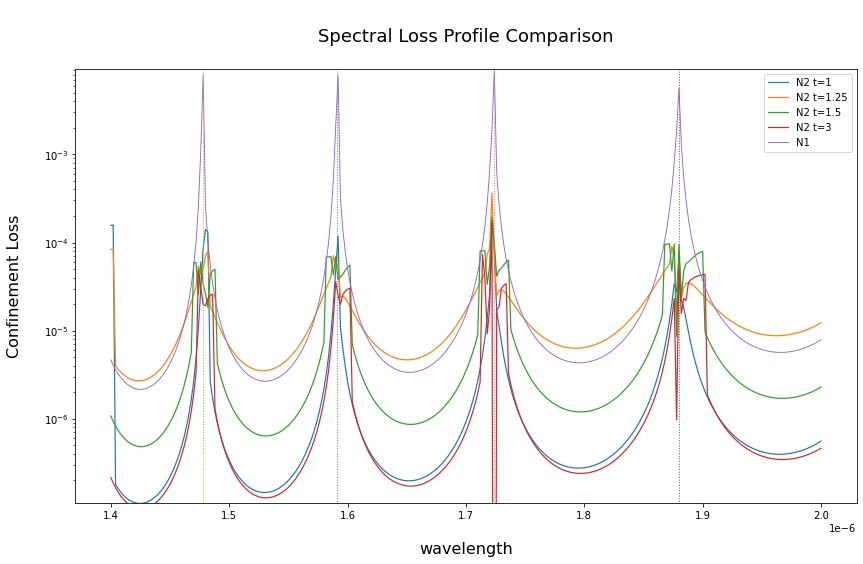

In [82]:
%matplotlib inline

fig = plt.figure(figsize=(14,8))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag,linewidth=1.2, label='N2 t=1')
ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
ax.plot(wls, -N2betas_t3.imag, linewidth=1.2, label='N2 t=3')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')

ax.legend()
ax.set_ylim(min(-N2betas_base.imag))
ax.set_yscale('log')

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T=5

In [31]:
centers = N2betas_t1.real


In [32]:
N2betas_t5 = np.zeros_like(wls, dtype=complex)

t1 = 5
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess )
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t5[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33171123252654-2.0931522822990647e-05j) . Residual of determinant:  7.117866324745923e-12 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (67.2356384614303-2.1029927495345763e-05j) . Residual of determinant:  2.973099805113513e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14091557934657-2.424908793966128e-07j) . Residual of determinant:  2.7850773221167213e-11 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.04538218323445-2.2515270642725602e-07j) . Residual of determinant:  6.1477250133068194e-12 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95012119798548-2.1145546780889678e-07j)

Scaled beta:  (63.691590609636805-2.128248149595899e-05j) . Residual of determinant:  8.70388304190217e-14 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.605536622017794-2.209813184114218e-05j) . Residual of determinant:  2.0431539860838262e-13 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.52127009354868-1.6957814777265617e-06j) . Residual of determinant:  2.3074368090199374e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (63.43563974554475-1.2724620860879235e-06j) . Residual of determinant:  3.0170931976602116e-12 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled beta:  (63.35028137553286-1.0031036240459814e-06j) . Residual of determinant:  2.5949017765031095e-12 


     --------------------  46/301: wavelength: 1.49e-06

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (60.34801560904051-7.642398940937782e-07j) . Residual of determinant:  6.377842325719047e-12 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

Scaled beta:  (60.270814934893565-8.940234682890542e-07j) . Residual of determinant:  7.437170922214338e-12 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.1938100287249-1.0629781753922709e-06j) . Residual of determinant:  1.5770458864086463e-12 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

Scaled beta:  (60.11699985345941-1.2873059846677536e-06j) . Residual of determinant:  2.384037775943238e-12 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (60.04038331222129-1.5918340799525843e-06j) . Residual of determinant:  8.124463475403671e-12 


     ----

Scaled beta:  (57.47733262944551-3.21356352515539e-07j) . Residual of determinant:  3.966669191833866e-11 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.40730026510541-3.1794292720566466e-07j) . Residual of determinant:  5.197574089240695e-11 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

Scaled beta:  (57.337438468907756-3.1604320139338786e-07j) . Residual of determinant:  4.130727962545855e-11 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.26774658002397-3.1560401403912927e-07j) . Residual of determinant:  9.366374517788522e-12 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

scaling guess: 1
Scaled beta:  (57.19822394458871-3.165996313982759e-07j) . Residual of determinant:  1.5210550008559525e-11 


     --------------------  126/301: wa

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (54.7086540630448-9.385023269146656e-05j) . Residual of determinant:  1.7498084308766761e-15 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.67580118944052-2.5109846957231836e-05j) . Residual of determinant:  3.3291406924678275e-14 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

Scaled beta:  (54.61450446580651-1.0331211762670797e-05j) . Residual of determinant:  5.07456091946049e-13 


     --------------------  165/301: wavelength: 1.7279999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.551816907266-1.6320196451463447e-05j) . Residual of determinant:  3.153732329392979e-13 


     --------------------  166/301: wavelength: 1.73e-06  --------------------     

Scaled beta:  (54.48738073325945-3.859215356027513e-06j) . Residual of determinant:  1.3

Scaled beta:  (52.36692183166356-4.6517153647639736e-07j) . Residual of determinant:  4.674332565991486e-11 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

Scaled beta:  (52.30877819863442-4.7580258525228794e-07j) . Residual of determinant:  4.5168306241290784e-11 


     --------------------  203/301: wavelength: 1.804e-06  --------------------     

Scaled beta:  (52.25076342776643-4.882712768576786e-07j) . Residual of determinant:  2.4196579932944614e-12 


     --------------------  204/301: wavelength: 1.806e-06  --------------------     

Scaled beta:  (52.19287707194486-5.027304833940137e-07j) . Residual of determinant:  6.604414580493286e-12 


     --------------------  205/301: wavelength: 1.8079999999999999e-06  --------------------     

Scaled beta:  (52.13511868568347-5.193650062988283e-07j) . Residual of determinant:  4.7898121703028874e-12 


     --------------------  206/301: wavelength: 1.8099999999999998e-06  ---

scaling guess: 1
scaling guess: 2
Scaled beta:  (50.19847902069608-2.2529234957606223e-06j) . Residual of determinant:  2.009114830836064e-11 


     --------------------  241/301: wavelength: 1.8799999999999998e-06  --------------------     

Scaled beta:  (50.13815907642868-2.6582454633231988e-05j) . Residual of determinant:  1.7658602616687955e-14 


     --------------------  242/301: wavelength: 1.882e-06  --------------------     

Scaled beta:  (50.08871633967997-1.1588718435711999e-05j) . Residual of determinant:  1.390318301736921e-12 


     --------------------  243/301: wavelength: 1.8839999999999999e-06  --------------------     

Scaled beta:  (50.03399918041924-1.8315264218909084e-05j) . Residual of determinant:  3.5383960858179113e-14 


     --------------------  244/301: wavelength: 1.8859999999999998e-06  --------------------     

Scaled beta:  (49.98087996232394-1.9449793641879103e-05j) . Residual of determinant:  1.1603593623136432e-12 


     --------------------

scaling guess: 1
Scaled beta:  (48.13997981908958-6.158836089460921e-07j) . Residual of determinant:  2.312174725386658e-11 


     --------------------  281/301: wavelength: 1.96e-06  --------------------     

Scaled beta:  (48.090834490390044-6.188814808135525e-07j) . Residual of determinant:  2.7480072452907798e-11 


     --------------------  282/301: wavelength: 1.962e-06  --------------------     

Scaled beta:  (48.04178940059823-6.232830562798944e-07j) . Residual of determinant:  7.275239537273206e-12 


     --------------------  283/301: wavelength: 1.9639999999999997e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (47.99284422840047-6.291128710702915e-07j) . Residual of determinant:  5.510753738293042e-12 


     --------------------  284/301: wavelength: 1.966e-06  --------------------     

Scaled beta:  (47.94399865445017-6.36408085396103e-07j) . Residual of determinant:  8.390695364027151e-12 


     --------------------

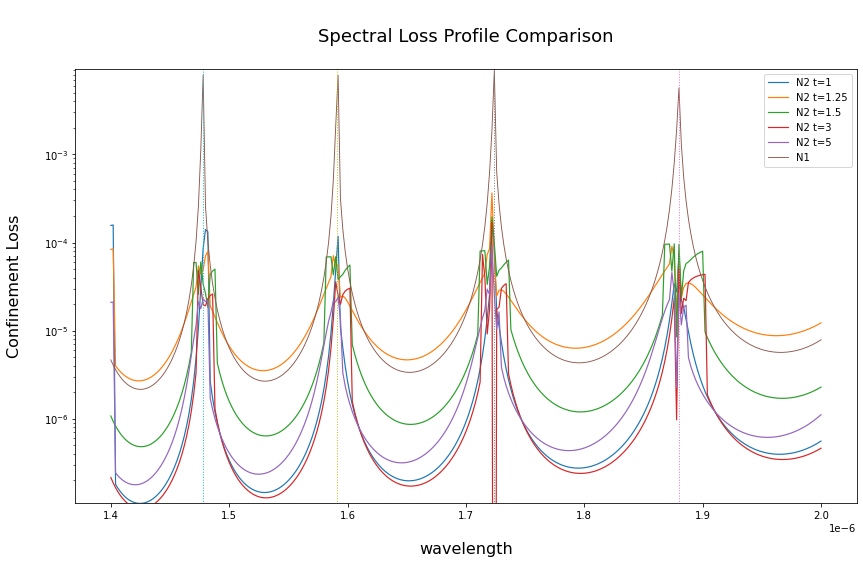

In [81]:
%matplotlib inline

fig = plt.figure(figsize=(14,8))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag,linewidth=1.2, label='N2 t=1')
ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
ax.plot(wls, -N2betas_t3.imag, linewidth=1.2, label='N2 t=3')
ax.plot(wls, -N2betas_t5.imag, linewidth=1.2, label='N2 t=5')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')

ax.legend()
ax.set_ylim(min(-N2betas_base.imag))
ax.set_yscale('log')

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T=7

In [34]:
centers = N2betas_t5.real


In [35]:
N2betas_t7 = np.zeros_like(wls, dtype=complex)

t1 = 7
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t7[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.3308773224233-1.7000965944154615e-05j) . Residual of determinant:  1.5012349075189826e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23518242135472-1.6978182882255274e-05j) . Residual of determinant:  3.952616564092257e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.14090804778715-1.403063955195476e-07j) . Residual of determinant:  6.330411797554158e-11 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04537535757494-1.2431288031667393e-07j) . Residual of determinant:  4.9821743536914166e-11 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.9501149261213-1.1195001686868095e-07j) . Residual of det

scaling guess: 1
scaling guess: 2
Scaled beta:  (63.77487134688459-2.7832885475912175e-05j) . Residual of determinant:  3.617666453671059e-15 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

Scaled beta:  (63.69102534888822-1.8762715042642386e-05j) . Residual of determinant:  1.4468269673699005e-12 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.605019067661814-1.900249074691778e-05j) . Residual of determinant:  2.1686473410658695e-12 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (63.52123016502128-8.110719539134413e-06j) . Residual of determinant:  6.210624569224712e-14 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

Scaled beta:  (63.43569615866754-1.1199941878483758e-05j) . Residual of determinant:  1.2848352196910164e-12 


     ------------------

Scaled beta:  (60.34800099801109-1.9872311943204933e-07j) . Residual of determinant:  2.1165022784446567e-11 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.27079819043977-2.224591325544434e-07j) . Residual of determinant:  3.2407609753379614e-11 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.193790549118845-2.521280319413742e-07j) . Residual of determinant:  1.8208985068954774e-11 


     --------------------  85/301: wavelength: 1.5679999999999999e-06  --------------------     

Scaled beta:  (60.11697679869781-2.8979461450153044e-07j) . Residual of determinant:  1.9590601648267962e-11 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.040355475521984-3.3853766247659775e-07j) . Residual of determinant:  1.3934231913239683e-12 


     --------------------  87/301: wavelength: 1.572e-

Scaled beta:  (57.40729264426266-1.48420065134242e-07j) . Residual of determinant:  2.4101216348084804e-11 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

Scaled beta:  (57.337430992560904-1.4393920401499418e-07j) . Residual of determinant:  1.2318215552476826e-11 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

Scaled beta:  (57.267739208922755-1.4033842271786814e-07j) . Residual of determinant:  3.6333014819019655e-11 


     --------------------  125/301: wavelength: 1.648e-06  --------------------     

Scaled beta:  (57.19821664200395-1.3753063964063336e-07j) . Residual of determinant:  1.2524399783950046e-11 


     --------------------  126/301: wavelength: 1.6499999999999999e-06  --------------------     

Scaled beta:  (57.1288626457504-1.354491930226017e-07j) . Residual of determinant:  5.1370879105568056e-11 


     --------------------  127/301: wavelength: 1.652e-06  -------------

scaling guess: 1
Scaled beta:  (54.70544733164723-0.00010642815156599701j) . Residual of determinant:  1.3654366167453283e-15 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

Scaled beta:  (54.67453068100765-2.1465494021809787e-05j) . Residual of determinant:  8.102819664739309e-16 


     --------------------  164/301: wavelength: 1.7259999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.61485266072283-7.862771882591146e-06j) . Residual of determinant:  3.788470069932183e-13 


     --------------------  165/301: wavelength: 1.7279999999999998e-06  --------------------     

Scaled beta:  (54.55181690539451-2.3057106260628866e-10j) . Residual of determinant:  0.26617828792810333 


     --------------------  166/301: wavelength: 1.73e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.48709487357099-7.170860853109258e-06j) . Residual of determinant:  2.015161351173923e-13 


     ------

Scaled beta:  (52.250753728157335-1.870646174726828e-07j) . Residual of determinant:  4.256994011819616e-11 


     --------------------  204/301: wavelength: 1.806e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.19286719210603-1.8873708346339427e-07j) . Residual of determinant:  3.4748808750836204e-11 


     --------------------  205/301: wavelength: 1.8079999999999999e-06  --------------------     

Scaled beta:  (52.13510858869194-1.9104266331450799e-07j) . Residual of determinant:  5.8043859009898385e-12 


     --------------------  206/301: wavelength: 1.8099999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.07747747113334-1.940053585003964e-07j) . Residual of determinant:  3.8265332623657464e-11 


     --------------------  207/301: wavelength: 1.8119999999999998e-06  --------------------     

Scaled beta:  (52.01997339316819-1.9765825100322904e-07j) . Residual of determinant:  4.3245173079365575e-12 


     --------------------

scaling guess: 1
Scaled beta:  (50.02963106249794-3.0162661299209586e-05j) . Residual of determinant:  3.3118819519494836e-13 


     --------------------  244/301: wavelength: 1.8859999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (49.98142299923876-1.297930713663113e-05j) . Residual of determinant:  8.843494532224095e-13 


     --------------------  245/301: wavelength: 1.888e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (49.92614368215692-9.101643182179344e-06j) . Residual of determinant:  3.352219779585671e-13 


     --------------------  246/301: wavelength: 1.89e-06  --------------------     

Scaled beta:  (49.873241317731264-7.984875891284087e-06j) . Residual of determinant:  3.1148135955696866e-13 


     --------------------  247/301: wavelength: 1.8919999999999998e-06  --------------------     

Scaled beta:  (49.82045920697786-9.811594645184743e-06j) . Residual of determinant:  

scaling guess: 1
Scaled beta:  (47.94398648425074-2.685101030155175e-07j) . Residual of determinant:  9.883606719149645e-12 


     --------------------  285/301: wavelength: 1.9679999999999996e-06  --------------------     

Scaled beta:  (47.89524014410034-2.67233122005355e-07j) . Residual of determinant:  1.504858386744167e-11 


     --------------------  286/301: wavelength: 1.9699999999999998e-06  --------------------     

Scaled beta:  (47.846592740445345-2.665860574259896e-07j) . Residual of determinant:  8.85262146023731e-12 


     --------------------  287/301: wavelength: 1.972e-06  --------------------     

Scaled beta:  (47.798043958563234-2.6655665204035207e-07j) . Residual of determinant:  1.4023797087936805e-11 


     --------------------  288/301: wavelength: 1.974e-06  --------------------     

Scaled beta:  (47.74959348489621-2.671385571624575e-07j) . Residual of determinant:  4.076087710205726e-12 


     --------------------  289/301: wavelength: 1.976e-06  --

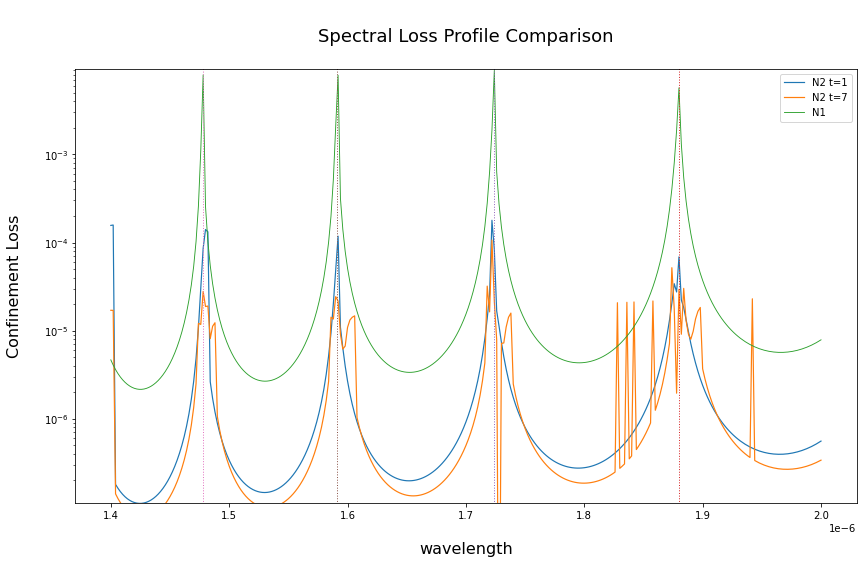

In [84]:
%matplotlib inline

fig = plt.figure(figsize=(14,8))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag,linewidth=1.2, label='N2 t=1')
# ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
# ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
# ax.plot(wls, -N2betas_t3.imag, linewidth=1.2, label='N2 t=3')
# ax.plot(wls, -N2betas_t5.imag, linewidth=1.2, label='N2 t=5')
ax.plot(wls, -N2betas_t7.imag, linewidth=1.2, label='N2 t=7')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')

ax.legend()
ax.set_ylim(min(-N2betas_base.imag))

ax.set_yscale('log')

for l in ls:
    ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T=8

In [37]:
centers = N2betas_t7.real


In [38]:
N2betas_t10 = np.zeros_like(wls, dtype=complex)

t1 = 8
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
#                 guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t10[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

Scaled beta:  (67.33094513661526-1.5472007017728626e-05j) . Residual of determinant:  2.8700196885370286e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

Scaled beta:  (67.23487171885739-1.5504442015969022e-05j) . Residual of determinant:  5.0433493153669854e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.14110023587736-1.0855924041660964e-05j) . Residual of determinant:  1.9774503233972183e-11 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04536982539716-4.693642318176922e-07j) . Residual of determinant:  8.018117659744814e-13 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95011018907624-4.069606932309293e-07j) . Residual of determinant:  7.16

Scaled beta:  (63.774807489285074-2.4717289385394446e-05j) . Residual of determinant:  2.648140834110734e-14 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

Scaled beta:  (63.69069944624067-1.741643847336582e-05j) . Residual of determinant:  4.009710969232624e-13 


     --------------------  42/301: wavelength: 1.482e-06  --------------------     

Scaled beta:  (63.604689914445906-1.7528738640467837e-05j) . Residual of determinant:  3.226278325196122e-12 


     --------------------  43/301: wavelength: 1.484e-06  --------------------     

Scaled beta:  (63.52133865549119-4.005055506496575e-06j) . Residual of determinant:  7.809997726516109e-13 


     --------------------  44/301: wavelength: 1.4859999999999998e-06  --------------------     

Scaled beta:  (63.43571748365637-5.048819339781403e-06j) . Residual of determinant:  8.139172735547188e-13 


     --------------------  45/301: wavelength: 1.488e-06  --------------------     

Scaled be

scaling guess: 1
Scaled beta:  (60.50301103912561-7.96932698508953e-06j) . Residual of determinant:  5.560398111841804e-13 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.42542259738588-9.84464255812402e-06j) . Residual of determinant:  1.1438422079425696e-12 


     --------------------  82/301: wavelength: 1.5619999999999998e-06  --------------------     

Scaled beta:  (60.34798580454854-3.7916053604740714e-06j) . Residual of determinant:  1.443074838296414e-12 


     --------------------  83/301: wavelength: 1.564e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.270842853519646-1.2065090520087701e-05j) . Residual of determinant:  1.442233002340946e-12 


     --------------------  84/301: wavelength: 1.566e-06  --------------------     

Scaled beta:  (60.19377580302627-2.4551924696974146e-06j) . Residual of determinant:  3.993771996706224e-15 


     --------------------  85/

Scaled beta:  (57.54752299478539-5.426745547668474e-07j) . Residual of determinant:  1.084107817452708e-12 


     --------------------  121/301: wavelength: 1.64e-06  --------------------     

Scaled beta:  (57.47732004808107-5.144868482253235e-07j) . Residual of determinant:  2.0941484230524176e-12 


     --------------------  122/301: wavelength: 1.642e-06  --------------------     

Scaled beta:  (57.407288239316294-4.931389695213639e-07j) . Residual of determinant:  4.188600567206221e-13 


     --------------------  123/301: wavelength: 1.6439999999999998e-06  --------------------     

Scaled beta:  (57.337426914450816-4.77966632699316e-07j) . Residual of determinant:  2.5989036975566994e-12 


     --------------------  124/301: wavelength: 1.646e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.267735424677404-4.6859527403812475e-07j) . Residual of determinant:  3.796771609121732e-12 


     --------------------  125/301: wavelength: 1.648e-

Scaled beta:  (54.93016278611474-4.4244127670726515e-06j) . Residual of determinant:  4.641874529810259e-13 


     --------------------  160/301: wavelength: 1.718e-06  --------------------     

Scaled beta:  (54.86461365797344-1.6703261218323464e-05j) . Residual of determinant:  9.27414239638254e-14 


     --------------------  161/301: wavelength: 1.7199999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (54.8018101585099-1.1855016171648638e-05j) . Residual of determinant:  9.221925153072459e-14 


     --------------------  162/301: wavelength: 1.7219999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.70594076337225-6.222690617988483e-05j) . Residual of determinant:  1.903223113592299e-15 


     --------------------  163/301: wavelength: 1.724e-06  --------------------     

Scaled beta:  (54.67322908784233-9.803661772068413e-05j) . Residual of determinant:  0.021903487107036154 


     --------------------  16

Scaled beta:  (52.48358436631661-6.622518286128703e-07j) . Residual of determinant:  7.612181287993608e-13 


     --------------------  200/301: wavelength: 1.798e-06  --------------------     

Scaled beta:  (52.42518187750143-6.841641423618314e-07j) . Residual of determinant:  7.006170576626698e-13 


     --------------------  201/301: wavelength: 1.8e-06  --------------------     

Scaled beta:  (52.36690912190167-7.157730324876529e-07j) . Residual of determinant:  1.4052313285843477e-12 


     --------------------  202/301: wavelength: 1.8019999999999999e-06  --------------------     

Scaled beta:  (52.30876565396615-7.591550999522852e-07j) . Residual of determinant:  9.631893899466741e-14 


     --------------------  203/301: wavelength: 1.804e-06  --------------------     

Scaled beta:  (52.25075103080508-8.172199021020512e-07j) . Residual of determinant:  5.158625137000197e-13 


     --------------------  204/301: wavelength: 1.806e-06  --------------------     

Scaled b

Scaled beta:  (50.297100547051706-9.839356531113885e-06j) . Residual of determinant:  6.87927558390653e-14 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

Scaled beta:  (50.24317960720265-1.5387531437106934e-05j) . Residual of determinant:  5.755071293065939e-13 


     --------------------  240/301: wavelength: 1.8779999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (50.19864280436357-1.3257934878476306e-06j) . Residual of determinant:  7.062862846372525e-12 


     --------------------  241/301: wavelength: 1.8799999999999998e-06  --------------------     

Scaled beta:  (50.13328785736306-3.3534575505113205e-05j) . Residual of determinant:  3.9543406833668804e-14 


     --------------------  242/301: wavelength: 1.882e-06  --------------------     

Scaled beta:  (50.088777798668126-8.303919094337172e-06j) . Residual of determinant:  2.639309301526055e-13 


     --------------------  243/301: wavelength: 1.88399999

scaling guess: 1
Scaled beta:  (48.18920654289159-9.291353969652625e-07j) . Residual of determinant:  2.698956187664536e-12 


     --------------------  280/301: wavelength: 1.9579999999999997e-06  --------------------     

Scaled beta:  (48.13996112435331-9.164983874059779e-07j) . Residual of determinant:  1.6591176321237105e-12 


     --------------------  281/301: wavelength: 1.96e-06  --------------------     

Scaled beta:  (48.09081621687256-9.102970668699139e-07j) . Residual of determinant:  9.060420693077691e-14 


     --------------------  282/301: wavelength: 1.962e-06  --------------------     

Scaled beta:  (48.04177150250655-9.107503048676271e-07j) . Residual of determinant:  2.8977279258351596e-12 


     --------------------  283/301: wavelength: 1.9639999999999997e-06  --------------------     

Scaled beta:  (47.99282666497686-9.182759562428923e-07j) . Residual of determinant:  7.158915961918341e-13 


     --------------------  284/301: wavelength: 1.966e-06  ---

(1.0933995805218813e-07, 0.008984411462170822)

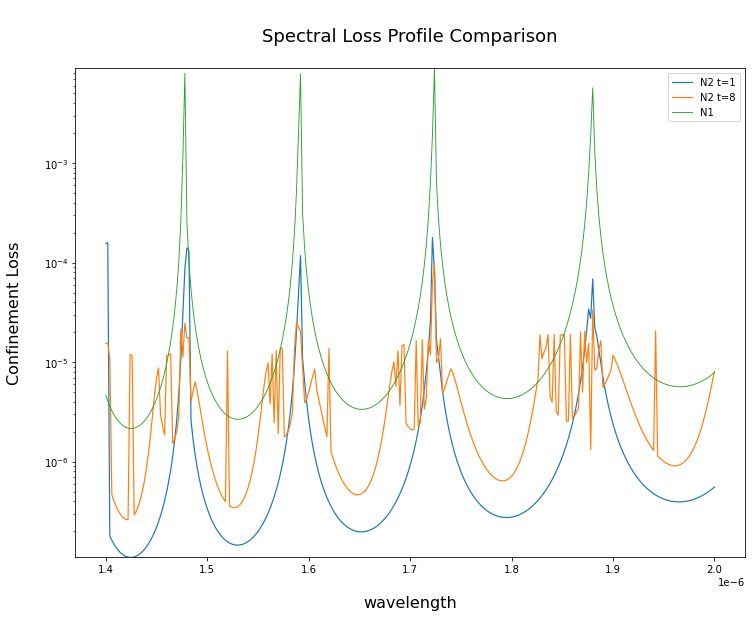

In [39]:
%matplotlib inline

fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag,linewidth=1.2, label='N2 t=1')
# ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
# ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
# ax.plot(wls, -N2betas_t3.imag, linewidth=1.2, label='N2 t=3')
# ax.plot(wls, -N2betas_t5.imag, linewidth=1.2, label='N2 t=5')
# ax.plot(wls, -N2betas_t7.imag, linewidth=1.2, label='N2 t=7')
ax.plot(wls, -N2betas_t10.imag, linewidth=1.2, label='N2 t=8')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')
#
ax.legend()

ax.set_yscale('log')
ax.set_ylim(min(-N2betas_base.imag), max(-N1betas.imag))
# for l in ls:
#     ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


# T = 12

In [40]:
centers = N2betas_t10.real


In [41]:
N2betas_t11 = np.zeros_like(wls, dtype=complex)

t1 = 40
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]


for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = BraggExact(ts=ts, wl=wl, ns=ns, no_mesh=True)

    k_low = A.ks[0] * A.scale
    guess = np.array(centers[i])
    imag = 0
    flag = True
    reduce = 0
    scaling = 1+1e-6
    while flag:
        try:
            x0 = np.array(guess)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
#                 guess *= 1/scaling
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= scaling
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    N2betas_t11[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (67.33126703754353-2.892282963565653e-06j) . Residual of determinant:  2.949971281687364e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.2351957301878-2.904007574548976e-06j) . Residual of determinant:  2.988834605650865e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

Scaled beta:  (67.14110023587736-1.4480307239385653e-45j) . Residual of determinant:  0.12132294300406715 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

Scaled beta:  (67.04536982539716-1.0440491800834014e-43j) . Residual of determinant:  0.01530918848724027 


     --------------------  5/301: wavelength: 1.408e-06  --------------------     

Scaled beta:  (66.95011018907624-2.2490258723021103e-43j) . Residual of determina

scaling guess: 1
Scaled beta:  (64.03801770574164-2.114147010659891e-06j) . Residual of determinant:  4.9676504176412315e-14 


     --------------------  38/301: wavelength: 1.474e-06  --------------------     

Scaled beta:  (63.94929723670187-4.407598830784687e-06j) . Residual of determinant:  3.16196869313106e-13 


     --------------------  39/301: wavelength: 1.476e-06  --------------------     

Scaled beta:  (63.86532111811949-3.2419162926628836e-31j) . Residual of determinant:  0.0005906915654351083 


     --------------------  40/301: wavelength: 1.4779999999999999e-06  --------------------     

Positive imaginary part, retrying.
scaling guess: 1
scaling guess: 2
Scaled beta:  (63.77488936838217-3.2112245400474655e-06j) . Residual of determinant:  8.432664718444928e-14 


     --------------------  41/301: wavelength: 1.48e-06  --------------------     

Scaled beta:  (63.690961728141644-3.0541160448566983e-06j) . Residual of determinant:  1.0861155060173093e-14 


     --

scaling guess: 1
Scaled beta:  (60.73698609365811-2.0981059580300487e-07j) . Residual of determinant:  1.66442275433013e-11 


     --------------------  78/301: wavelength: 1.5539999999999999e-06  --------------------     

Scaled beta:  (60.658792687604006-2.5634494573484864e-07j) . Residual of determinant:  1.6986286347987347e-12 


     --------------------  79/301: wavelength: 1.556e-06  --------------------     

scaling guess: 1
Scaled beta:  (60.580799861295745-3.2213400856167503e-07j) . Residual of determinant:  9.831254969011858e-12 


     --------------------  80/301: wavelength: 1.558e-06  --------------------     

Scaled beta:  (60.50300685441918-4.175692249441571e-07j) . Residual of determinant:  5.562909650200792e-13 


     --------------------  81/301: wavelength: 1.5599999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (60.42577633541615-2.786962309121281e-06j) . Residual of determinant:  9.262759288537142e-

scaling guess: 1
scaling guess: 2
Scaled beta:  (57.90123465455612-2.9954000940632842e-06j) . Residual of determinant:  2.837315885274744e-12 


     --------------------  116/301: wavelength: 1.6299999999999999e-06  --------------------     

Scaled beta:  (57.8300689464091-1.4123713844979314e-07j) . Residual of determinant:  1.088548677293799e-12 


     --------------------  117/301: wavelength: 1.6319999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.75937802429943-3.063390421619408e-06j) . Residual of determinant:  2.973526670289593e-12 


     --------------------  118/301: wavelength: 1.634e-06  --------------------     

Scaled beta:  (57.68845319879896-1.1973239700041615e-07j) . Residual of determinant:  7.610223828322477e-12 


     --------------------  119/301: wavelength: 1.6359999999999999e-06  --------------------     

Scaled beta:  (57.61790550885363-1.1269089023201389e-07j) . Residual of determinant:  1.44

scaling guess: 1
Scaled beta:  (55.252851181521194-3.2498970256613757e-06j) . Residual of determinant:  3.0729190138610347e-13 


     --------------------  155/301: wavelength: 1.708e-06  --------------------     

Scaled beta:  (55.18799995405839-9.344666268050601e-07j) . Residual of determinant:  6.8191852165587e-13 


     --------------------  156/301: wavelength: 1.71e-06  --------------------     

Scaled beta:  (55.123383967756475-1.1041005389475107e-06j) . Residual of determinant:  1.5055647820533764e-12 


     --------------------  157/301: wavelength: 1.7119999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (55.05961267288591-3.431597651483993e-06j) . Residual of determinant:  6.245638039765019e-13 


     --------------------  158/301: wavelength: 1.714e-06  --------------------     

Scaled beta:  (54.99442275172931-2.336660332098284e-06j) . Residual of determinant:  3.3964325247584166e-13 


     --------------------  159/301: wa

Scaled beta:  (52.718508704110896-1.35766159328753e-07j) . Residual of determinant:  8.143926972023138e-12 


     --------------------  196/301: wavelength: 1.7899999999999998e-06  --------------------     

Scaled beta:  (52.65958257544253-1.3560219248663822e-07j) . Residual of determinant:  8.358273592817813e-12 


     --------------------  197/301: wavelength: 1.792e-06  --------------------     

scaling guess: 1
Scaled beta:  (52.6007880159973-1.3633085453219287e-07j) . Residual of determinant:  4.289922887717089e-12 


     --------------------  198/301: wavelength: 1.7939999999999999e-06  --------------------     

Scaled beta:  (52.542124566670715-1.3794919204212946e-07j) . Residual of determinant:  6.914478591538351e-13 


     --------------------  199/301: wavelength: 1.7959999999999998e-06  --------------------     

Scaled beta:  (52.483591771216346-1.4047977108672033e-07j) . Residual of determinant:  9.410349332246046e-13 


     --------------------  200/301: wavelengt

scaling guess: 1
Scaled beta:  (50.459266739299395-2.841177622846882e-06j) . Residual of determinant:  1.543793204525224e-14 


     --------------------  236/301: wavelength: 1.8699999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (50.405268843819144-3.6593269130490266e-06j) . Residual of determinant:  6.090038898026044e-14 


     --------------------  237/301: wavelength: 1.8719999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (50.35190953152126-4.235512099443163e-06j) . Residual of determinant:  1.1025857529919216e-12 


     --------------------  238/301: wavelength: 1.8739999999999998e-06  --------------------     

Scaled beta:  (50.29762612087028-4.235044432361549e-06j) . Residual of determinant:  1.6451886036329483e-13 


     --------------------  239/301: wavelength: 1.876e-06  --------------------     

Scaled beta:  (50.2431605986162-5.05

scaling guess: 1
Scaled beta:  (48.486820714696016-2.249342183448849e-07j) . Residual of determinant:  1.9466532559347077e-12 


     --------------------  274/301: wavelength: 1.9459999999999997e-06  --------------------     

Scaled beta:  (48.43696496849286-2.159370851960331e-07j) . Residual of determinant:  3.3432647340299284e-12 


     --------------------  275/301: wavelength: 1.948e-06  --------------------     

Scaled beta:  (48.387211730658414-2.0874313065779345e-07j) . Residual of determinant:  5.31127056639549e-12 


     --------------------  276/301: wavelength: 1.95e-06  --------------------     

Scaled beta:  (48.33756066689157-2.0309411184874116e-07j) . Residual of determinant:  3.4661509323077415e-12 


     --------------------  277/301: wavelength: 1.952e-06  --------------------     

Scaled beta:  (48.28801144547158-1.9879636884622277e-07j) . Residual of determinant:  6.454162646944246e-12 


     --------------------  278/301: wavelength: 1.954e-06  -----------

(1.0933995805218813e-07, 0.008984411462170822)

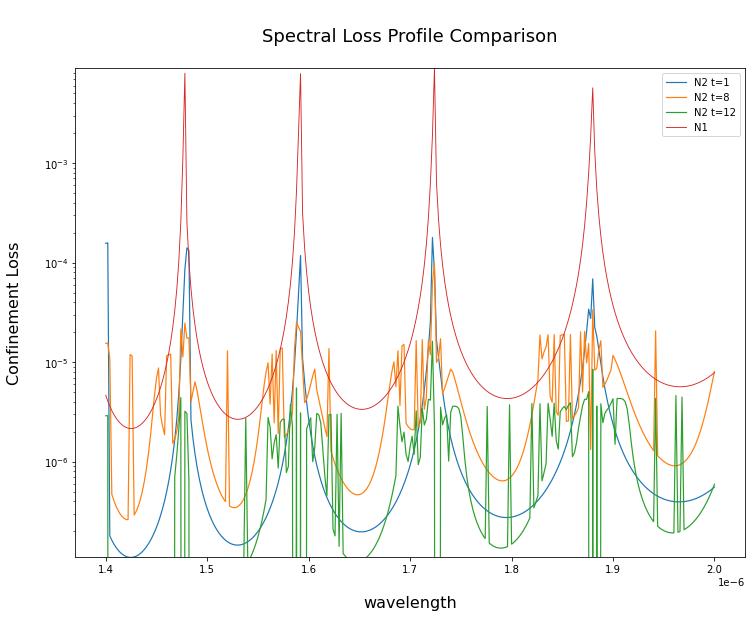

In [42]:
%matplotlib inline

fig = plt.figure(figsize=(12,9))

ax = plt.gca()
ax.set_title('\nSpectral Loss Profile Comparison\n', fontsize=18)
ax.set_xlabel('\nwavelength', fontsize=16)
ax.set_ylabel('Confinement Loss\n', fontsize=16)

ax.plot(wls, -N2betas_base.imag,linewidth=1.2, label='N2 t=1')
# ax.plot(wls, -N2betas_t1.imag, linewidth=1.2, label='N2 t=1.25')
# ax.plot(wls, -N2betas_t2.imag, linewidth=1.2, label='N2 t=1.5')
# ax.plot(wls, -N2betas_t3.imag, linewidth=1.2, label='N2 t=3')
# ax.plot(wls, -N2betas_t5.imag, linewidth=1.2, label='N2 t=5')
# ax.plot(wls, -N2betas_t7.imag, linewidth=1.2, label='N2 t=7')
ax.plot(wls, -N2betas_t10.imag, linewidth=1.2, label='N2 t=8')
ax.plot(wls, -N2betas_t11.imag, linewidth=1.2, label='N2 t=12')
ax.plot(wls, -N1betas.imag, linewidth=.9, label='N1')
#
ax.legend()

ax.set_yscale('log')
ax.set_ylim(min(-N2betas_base.imag), max(-N1betas.imag))
# for l in ls:
#     ax.plot([l,l], [m, M],  linewidth=1, linestyle=':')


In [43]:
t1 = 40
d = 4.0775e-05
ts = [d , 1e-5, t1 * d, 1.5e-5]
A = BraggExact(ts=ts, wl=wl, ns=ns)


In [44]:
goodwls = wls[np.where((wls<1.66e-6)*(wls>1.65e-6))]
goodbetas = N2betas_t11[np.where((wls<1.66e-6)*(wls>1.65e-6))]


In [68]:
A = BraggExact(ts=ts, wl=goodwls[1], ns=ns, maxhs=[.1,.01,.03,1])
Fs = A.all_fields(goodbetas[1], nu, outer)

In [60]:
Draw(Fs['Etv'].real, A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [69]:
Draw(-Fs['Ey'], A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene